In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import torchaudio
from torch.utils.data import Dataset
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import librosa
from birdsong_dataset import AudioDataset


Loading The Data...
Data Loaded !


In [4]:
df = pd.read_csv("./data/birdsong_metadata.csv")
df.nunique()

file_id                   264
genus                      66
species                    85
english_cname              88
who_provided_recording     68
country                    18
latitude                  195
longitute                 198
type                       54
license                     4
dtype: int64

In [32]:
import torch
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, name , species = sample[0], sample[1],sample[2]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))[:, :, :141]
        print(image.shape)
        return torch.from_numpy(image) , torch.from_numpy(name) , torch.from_numpy(species)

In [33]:
dataset = AudioDataset(transform = ToTensor())

Loading The Data...
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)


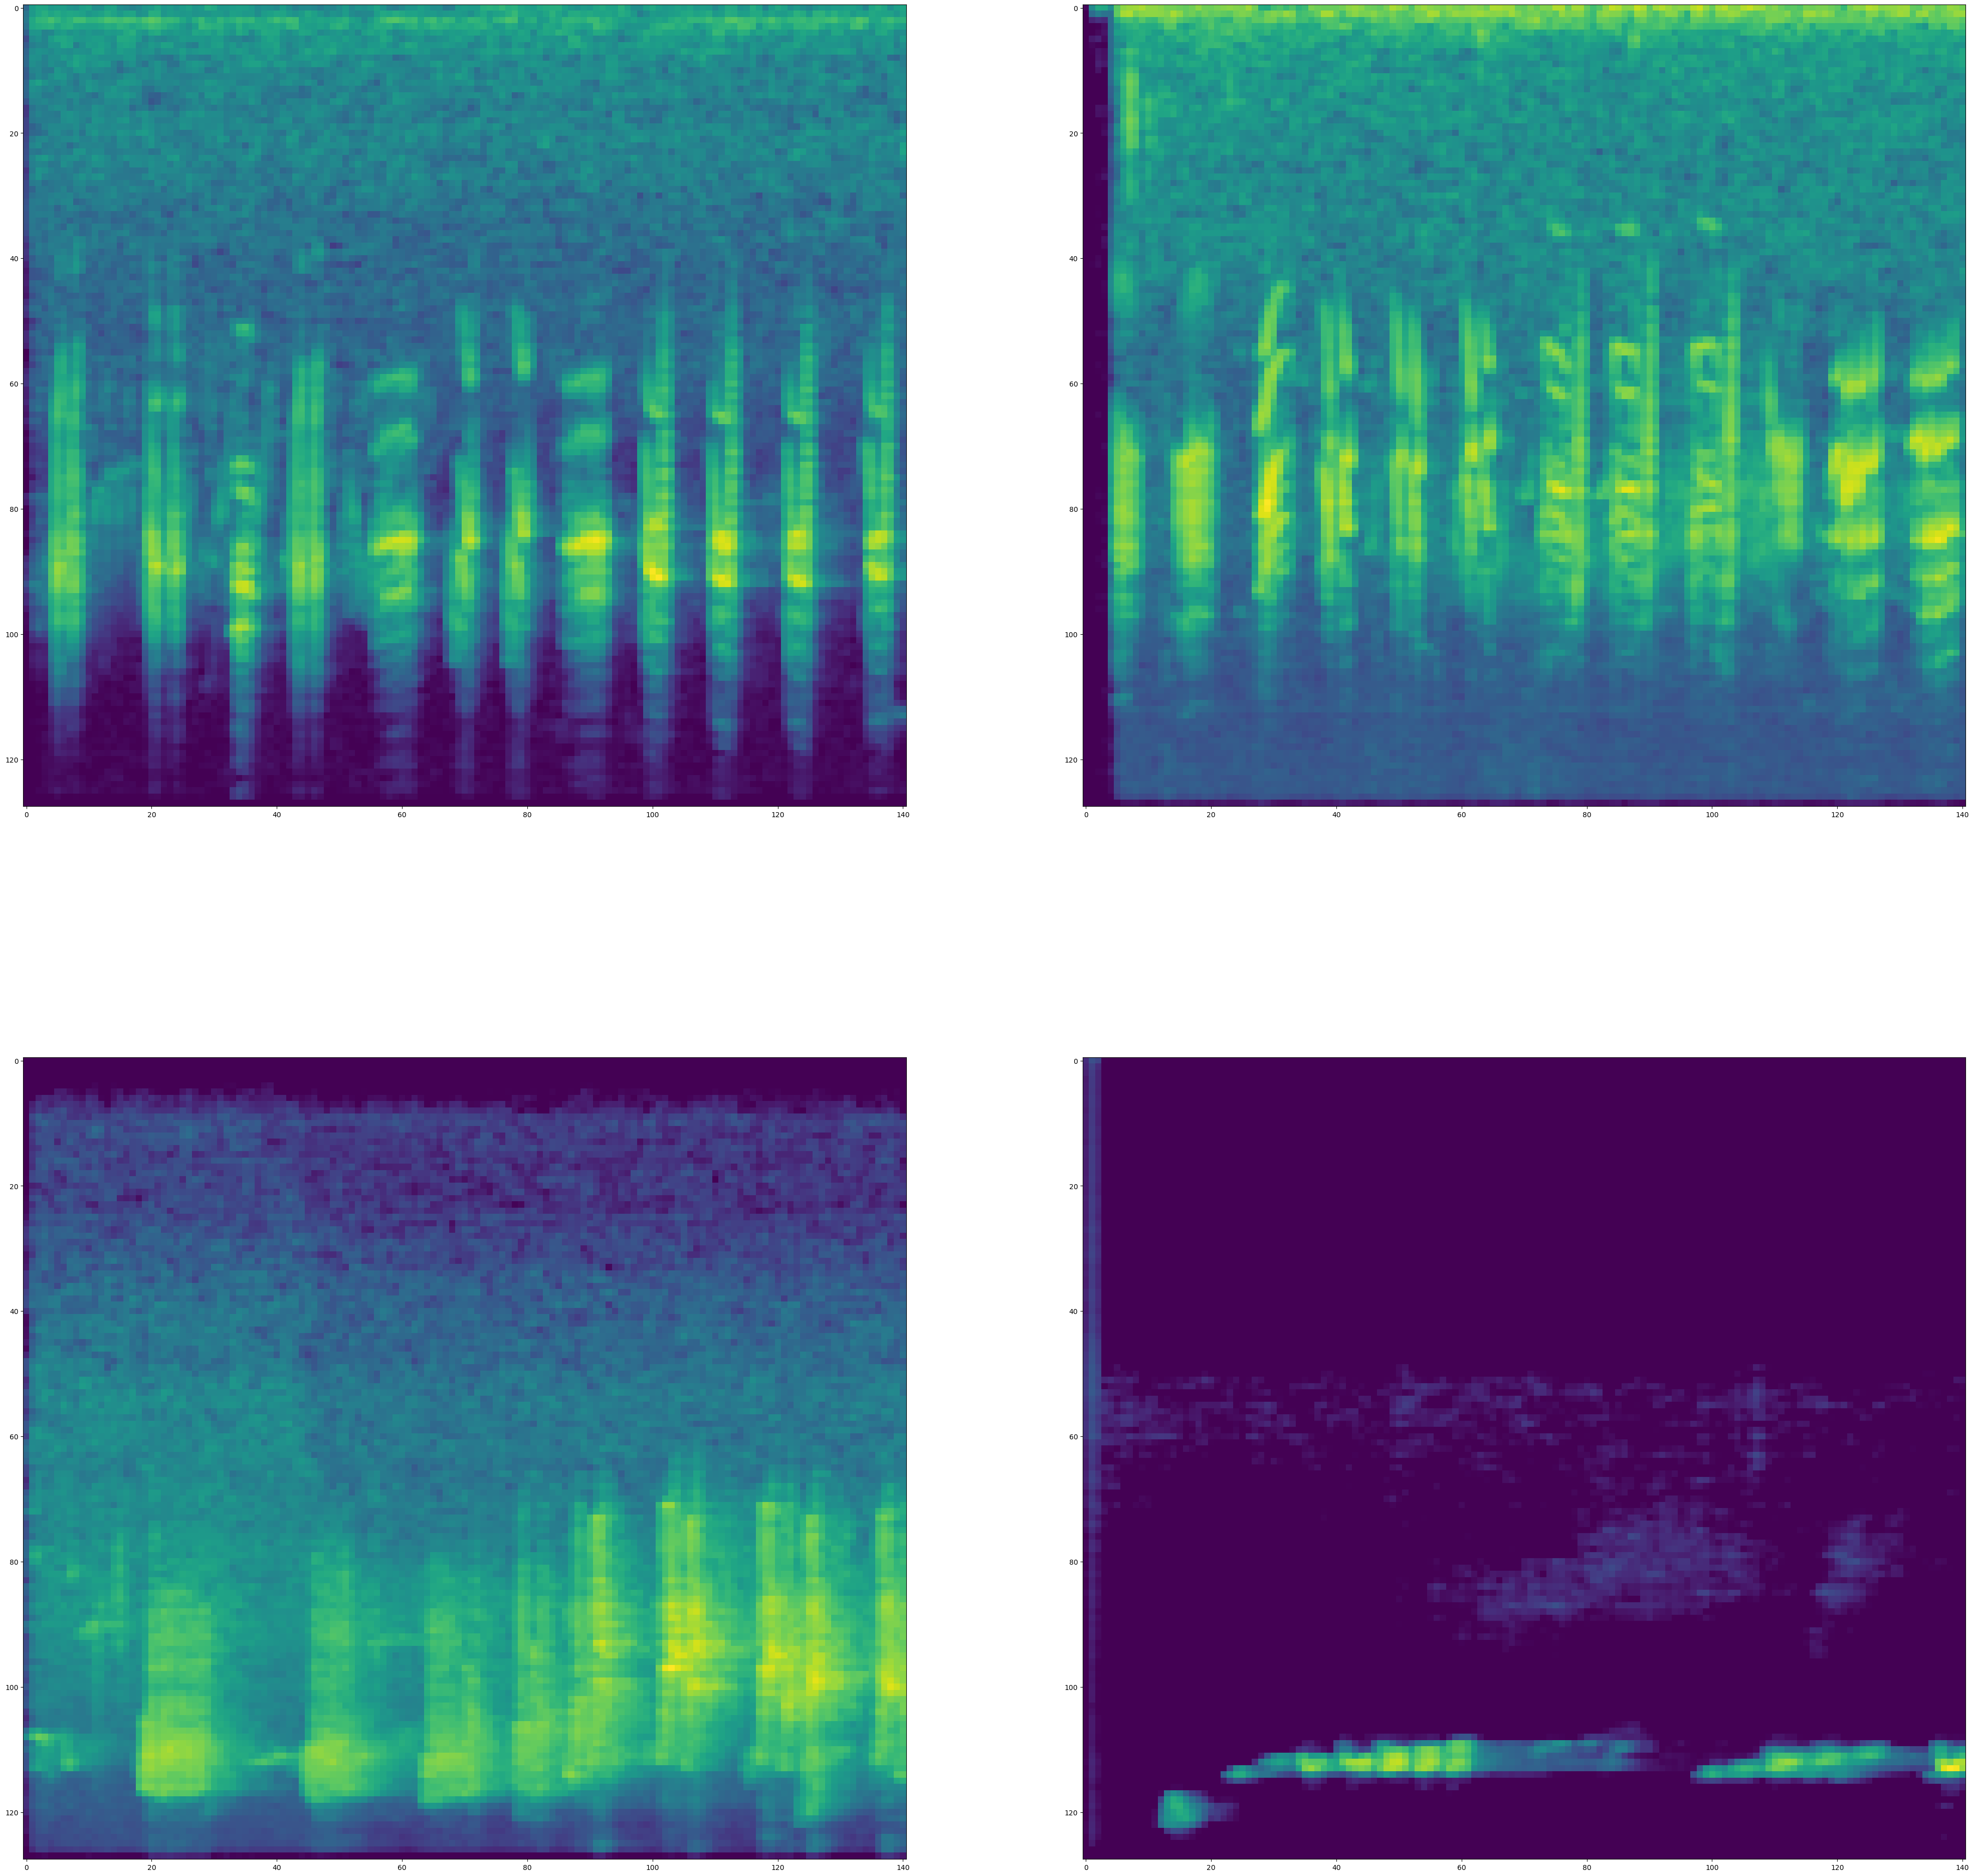

In [36]:
from matplotlib import pyplot as plt
plt.figure(figsize=(50,50))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(dataset[i+10][0].to('cpu').numpy().transpose((1,2,0)))

In [37]:
from torch.utils.data import random_split, DataLoader

# Assuming you have your dataset object named 'dataset' and the total size of the dataset is 'len(dataset)'
# Define the sizes of your desired splits
train_size = int(0.6 * len(dataset))  # 80% of the data for training
val_size = int(0.25 * len(dataset))    # 10% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to create the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 1
# You can then create data loaders for each split if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [64]:
len(train_loader) , len(val_loader) , len(test_loader)
min = 20000
for (audio , name , species) in train_loader:
    lenght = audio.shape[3]
    # print(lenght)
    if lenght < min : 
        min = lenght
print(min)

141


In [68]:
from torch import nn
import torch


class BirdSongClassifier(nn.Module):
    def __init__(self, num_classes_1 = 85 , num_classes_2 = 88):
        super(BirdSongClassifier,self).__init__()
        # backbone
        self.conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,3))
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,3))
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,3))

        # multilabel classification for name 
        
        self.names_l1 = nn.Linear(64*3*4 , 512 )
        self.names_relu1 = nn.ReLU()
        self.names_l2 = nn.Linear(512 , num_classes_1 )
        
        # multilabel classification for species       
        
        self.species_l1 = nn.Linear(64*3*4 , 512 )
        self.species_relu1 = nn.ReLU()
        self.species_l2 = nn.Linear(512 , num_classes_2 )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        backbone = self.pool3(x)
        print("Backbone Shape : ", backbone.size())
        #forward for names
        x1 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2))
        x1 = self.names_l1(x1)
        x1 = self.names_relu1(x1)
        x1 = self.names_l2(x1)
        print("Name Head Shape = " ,x1.shape)

        #forward for species
        x2 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2))
        x2 = self.species_l1(x2)
        x2 = self.species_relu1(x2)
        x2 = self.species_l2(x2)
        print("Species Head Shape = " ,x2.shape)
        return x1 , x2 

model = BirdSongClassifier()
pred = model(train_dataset[0][0])
print(pred[0].shape)
print(pred[1].shape)
        

Backbone Shape :  torch.Size([64, 3, 4])
Name Head Shape =  torch.Size([1, 85])
Species Head Shape =  torch.Size([1, 88])
torch.Size([1, 85])
torch.Size([1, 88])


In [73]:
print(torch.argmax(pred[0]).item() ,torch.argmax(pred[1]).item())

42 19


In [ ]:
def train():
    pass

In [114]:
# x = dataset[0][0]
# print(x.shape)
# conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)(x)
# relu1 = nn.ReLU()(conv1)
# pool1 = nn.MaxPool2d((3,3))(relu1)
# conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)(pool1)
# relu2 = nn.ReLU()(conv2)
# pool2 = nn.MaxPool2d((3,3))(relu2)
# conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)(pool2)
# relu3 = nn.ReLU()(conv3)
# pool3 = nn.MaxPool2d((3,3))(relu3)
# print(pool3.shape)



In [ ]:
# sgram = librosa.stft(ds[1][0]
# # librosa.display.specshow(sgram)
# sgram_mag, _ = librosa.magphase(sgram)
# mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=ds[0][1])
# # librosa.display.specshow(mel_scale_sgram)
# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
# # librosa.display.specshow(mel_sgram, sr=ds[0][1], x_axis='time', y_axis='mel',hop_length=512)